In [1]:
import numpy as np
import os, glob
from numba.decorators import autojit
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.animation as animation
from IPython.display import HTML
from scipy.ndimage import convolve

In [3]:
class ElecpySession(object):
    
    def __init__(self, path):
        
        self.path = path
        self.data = {}
        
        vmem_files = sorted( glob.glob(os.path.join(self.path, 'vmem*.npy')))
        phie_files = sorted( glob.glob(os.path.join(self.path, 'phie*.npy')))
        assert len(vmem_files) ==  len(phie_files)
        self.L = len(vmem_files)
        _img_vmem = np.load( vmem_files[0])
        _img_phie = np.load( phie_files[0])       
        assert _img_vmem.shape == _img_phie.shape
        
        self.data['vmem'] = np.zeros(np.concatenate(([self.L], _img_vmem.shape)), dtype=_img_vmem.dtype)
        self.data['phie'] = np.zeros(np.concatenate(([self.L], _img_phie.shape)), dtype=_img_phie.dtype)        
        for i, _f in enumerate(vmem_files): self.data['vmem'][i,:,:] = np.load(_f)
        for i, _f in enumerate(phie_files): self.data['phie'][i,:,:] = np.load(_f)
            
    def getNormalized(self):
            
        ret = ElecpySession (self.path)
        
        def pixelwise_normalize(X):
            L, M, N = X.shape
            ret = np.zeros_like(X)
            for i in range(M):
                for j in range(N):
                    ts = X[:,i,j]
                    ret[:, i, j] = (ts-ts.min())/(abs(ts.max() - ts.min())+1.0e-30)
            return ret
                    
        _func = autojit(pixelwise_normalize)
        for key in self.data.keys():
            ret.data[key] = _func(self.data[key])
        
        return ret
    
    def saveAnimation(self, save_dir, keys=None, time_range=None):
        
        if keys is None : keys = self.data.keys()
        if time_range is None : time_range = np.arange(self.L)
            
        for key in keys:

            fig = plt.figure()
            plt.axis('off')
            data = self.data[key]
            vmin = data.min()
            vmax = data.max()

            ims = []
            for i, img in enumerate(data[time_range]):
                im = plt.imshow(
                    img,
                    vmin = vmin, vmax = vmax,
                    cmap='hot',
                    interpolation='nearest')
                ims.append([im])

            ani = animation.ArtistAnimation(fig, ims, interval=30)
            ani.save(os.path.join(save_dir, '{0}.gif'.format(key)), writer="imagemagick")
            
    def pseudoECG(self, i, j):
        
        eta = np.ones((3,3), dtype=np.float64)
        
        k = np.ones((3,3), dtype=np.float64)
        k[1,1] = -8.
        
        k = k*eta
        
        phie = self.data['phie']                
        L,M,N = phie.shape

        def pixelwise_distance(pos_y, pos_x, pos_z = 0.):
            dist = np.zeros((M, N))
            for i_ in range(M):
                for j_ in range(N):
                    dist[i_, j_] = np.sqrt( pos_z**2 + (pos_y - i_)**2 + (pos_x -  j_)**2 )
            return dist                    
        im_dist = autojit(pixelwise_distance)(i, j)
        im_dist[i, j] = 1.0 ## to avoid zero division

        def framewise_ecg():
            ecg = np.zeros((L))
            for f in range(L):
                im_conv = convolve(phie[f,:,:], k, mode='constant', cval=0.)
                im_mul = im_conv/im_dist
                im_mul[i, j] = 0.0
                ecg[f] = np.sum(im_mul)
            return ecg
        ecg = autojit(framewise_ecg)()
        return ecg
        
        

## Sample

In [9]:
path = '/mnt/recordings/SimulationResult/20180506-1/'
# !ls /mnt/recordings/SimulationResult/2018-02-01/

In [10]:
sess = ElecpySession(path)
len(sess.data['vmem'])

26

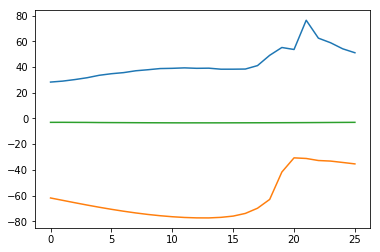

In [11]:
pos_y, pos_x = (100,100)
ecg = sess.pseudoECG(pos_y, pos_x)
plt.plot(ecg)
plt.plot(sess.data['vmem'][:,pos_y, pos_x])
plt.plot(sess.data['phie'][:,50,50])

In [8]:
def calc_ecg(phie):
    all_ecg = np.zeros_like(phie)
    L, M, N = phie.shape
    for i in range(M):
        for j in range(N):
            ecg = sess.pseudoECG(i, j)
            all_ecg[:,i,j] = ecg
    return all_ecg
all_ecg = autojit(calc_ecg)(sess.data['phie'])

KeyboardInterrupt: 

In [ ]:
plt.plot(all_ecg[:,140,140])

In [ ]:
sess.data['ecg'] = all_ecg[]

#sess.saveAnimation('./', keys=['vmem'], time_range=np.arange(50))
sess.saveAnimation('./', keys=['ecg'], time_range=np.arange(500))

In [ ]:
offset = 25
interval = 25

X = np.arange(offset, all_ecg.shape[2]-offset, interval)
Y = np.arange(offset, all_ecg.shape[1]-offset, interval)
X,Y

In [ ]:
sparse_ecg  = np.zeros(( all_ecg.shape[0] ,len(Y), len(X)))
for i, y in enumerate(Y):
    for j, x in enumerate(X):
        sparse_ecg[:, i, j] = all_ecg[:, y, x]
sparse_ecg.shape

In [ ]:
sess.data['sp_ecg'] = sparse_ecg
sess.saveAnimation('./', keys=['sp_ecg'])

In [ ]:
sparse_ecg_sub = np.array([img - sparse_ecg[f,0,0] for f, img in enumerate(sparse_ecg)])

In [ ]:
#plt.plot(sparse_ecg[:,1,1])
#plt.plot(sparse_ecg_sub[:,0,2])
plt.plot(sparse_ecg_sub[:,1,0])
plt.plot(sparse_ecg_sub[:,0,1])
#plt.plot(sparse_ecg_sub[:,2,2])


In [ ]:
plt.imshow(sparse_ecg_sub[0,:,:], interpolation='nearest')

In [ ]:
sess.data['sp_ecg_sub'] = sparse_ecg_sub
sess.saveAnimation('./', keys=['sp_ecg_sub'])

In [ ]:
sparse_ecg_sub_resize = np.array([imresize(img, (200,200), interp='bilinear') for img in sparse_ecg_sub])


sess.data['sp_ecg_sub_resize'] = sparse_ecg_sub_resize
sess.saveAnimation('./', keys=['sp_ecg_sub_resize'])

In [ ]:
sparse_ecg_resize = np.array([imresize(img, (200,200), interp='bilinear') for img in sparse_ecg])
sess.data['sp_ecg_resize'] = sparse_ecg_resize
sess.saveAnimation('./', keys=['sp_ecg_resize'])